In [10]:
# import standard libraries
import numpy as np
import pandas as pd
import glob
import time
import os

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta


## import statistical library
from scipy.stats import spearmanr
import scipy.stats as stats
from scipy.stats import lognorm


# import viz libraries
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline


# import model libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.utils.vis_utils import plot_model

In [11]:
def get_crude_oil_forecast():

        # ----- initiate workspace -----
        # set date
        today_date = date.today()
        days = pd.date_range(start=today_date, periods=14)
        yesterday = today_date - timedelta(days=1)
        yesterday = yesterday.strftime("%Y-%m-%d")
        today_date = today_date.strftime("%Y-%m-%d")

        # set file path
        crude = "../historical-dataset/Crude Oil Prices.csv"

        # load dataset
        main_crude = pd.read_csv(crude, parse_dates=["Date"], index_col=["Date"]).sort_index(ascending=True)
        main_crude = main_crude[:yesterday] # take data 'till the last closed price

        # load trained model
        use_model = load_model("../models/crude-oil-model.h5")

        # ----- load and read dataframe -----

        # copy dataframe, find price difference between monday to monday
        main_df = main_crude.copy()
        main_df = main_df[["Price"]] # only need price column
        main_df["DayName"] = main_df.index.day_name() # create new column that will contain day name for every given record dates
        main_df = main_df[main_df["DayName"]=="Monday"] # this will initiate a records between monday to monday
        main_df["PrevPriceWeek"] = main_df['Price'].shift() # shift data by one week
        main_df["PriceDiff"] = main_df['Price'] - main_df['PrevPriceWeek'] # subtract shifted values from original values
        main_df["PriceDiffAbs"] = main_df["PriceDiff"].abs() # take the absolute value of the differences


        # transform price differences to log-normal, calculate its mean and stdev 
        logweekly_df = main_df.copy()
        logweekly_df["DiffLogNorm"] = np.log(logweekly_df["PriceDiffAbs"]) # log-norm transform the differences
        logweekly_df = logweekly_df[logweekly_df['DiffLogNorm'] > 0] # filter, only take positive values

        log_difference = logweekly_df["DiffLogNorm"] # take log-norm values

        mean_difference = np.mean(log_difference) # calculate the mean log-norm distribution
        stdev_difference = np.std(log_difference) # calculate the stdev log-norm distribution



        # ----- predict future prices -----

        hist_df = main_crude[:yesterday].copy() # copy dataframe again
        
        # do some data preprocessing
        df = hist_df.reset_index()["Price"]
        scaler = MinMaxScaler(feature_range=(0,1))
        df = scaler.fit_transform(np.array(df).reshape(-1,1))

        train_size = int(len(df)*0.65)
        test_size = len(df) - train_size
        train_data, test_data = df[0:train_size,:], df[train_size:len(df),:1]

        x_input_test = test_data[-120:].reshape(1,-1) # 120 days window
        temp_input = list(x_input_test)
        temp_input = temp_input[0].tolist()

        # predict for 2 week (14 days)
        future_list = [] # initiate empty list
        n_steps = 120
        i = 0

        # set loop
        while(i<14):
                if (len(temp_input)>120):
                        x_input_test=np.array(temp_input[1:])
                        print("{} day input {}".format(i,x_input_test))
                        x_input_test = x_input_test.reshape(1,-1)
                        x_input_test = x_input_test.reshape((1,n_steps,1))
                        y_hat = use_model.predict(x_input_test, verbose=0)
                        print("{} day output {}".format(i, y_hat))
                        temp_input.extend(y_hat[0].tolist())
                        temp_input = temp_input[1:]
                        future_list.extend(y_hat.tolist())
                        i = i + 1
                else:
                        x_input_test = x_input_test.reshape((1,n_steps,1))
                        y_hat = use_model.predict(x_input_test, verbose=0)
                        print(y_hat[0])
                        temp_input.extend(y_hat[0].tolist())
                        print(len(temp_input))
                        future_list.extend(y_hat.tolist())
                        i = i + 1

        
        
        # ----- build dataframe that contain historical prices records and forecast records -----

        # build future dataframe with forecasted prices
        future_list = scaler.inverse_transform(future_list)
        future_df = pd.DataFrame(future_list)
        future_df.insert(0, "Date", days)
        future_df = future_df.rename(columns={0:"PredictPrice"})
        future_df["PredictPrice"] = future_df["PredictPrice"].round(2)
        future_df.sort_index(inplace=True)
        future_df = future_df.set_index(pd.DatetimeIndex(future_df["Date"])) # set index using date
        future_df.drop(columns="Date", inplace=True) # drop date column since already have datetimeindex
        future_df.columns = ["Price"] # rename column

   
        prices_df = hist_df[["Price"]].copy() # copy hist dataset
        new_rows = future_df[["Price"]] # take forecasted prices
        prices_df = prices_df.append(new_rows) # append historical + future prices



        # ----- calculate prices difference everyday on concanated dataframe -----

        prices_df["PrevPriceDay"] = prices_df['Price'].shift() # shift data by one day
        prices_df["PriceDiff"] = prices_df['Price'] - prices_df['PrevPriceDay'] # subtract prices
        prices_df["DistanceFromStdev"] = prices_df["PriceDiff"] / stdev_difference # calculate its distance (X/stdev lognorm)
        prices_df["DistanceAbs"] = prices_df["DistanceFromStdev"].abs() # take the absolute value of the distance



        # ----- build a dataframe with 95% confidence interval -----

        # calculate prices stdev every monday to monday
        stdweekly = prices_df[["Price"]] # take concanated dataframe prices
        stdweekly.columns = ["WeeklyPriceStdev"] # rename
        stdweekly = stdweekly.resample('W-MON').std() # resample and calculate its stdev
        stdweekly = stdweekly[:-1] # remove last stdev

        # calculate prices mean every monday to monday
        meanweekly = prices_df[["Price"]] # take concanated dataframe prices
        meanweekly.columns = ["WeeklyPriceMean"] # rename
        meanweekly = meanweekly.resample('W-MON').mean() # resample and calculate its mean
        meanweekly = meanweekly[:-1] # remove last mean

        # join mean and stdev dataframe
        mean_stdev = stdweekly.join(meanweekly, how="outer")

        # join mean and stdev dataframe to concanated dataframe prices
        confidence_df  = prices_df.join(mean_stdev, how="outer")

        # calculate the confidence interval
        values = confidence_df['WeeklyPriceMean'] # take the weekly mean values
        uncertainty = confidence_df['WeeklyPriceStdev'] # take the weekly stdev values
        confidence_interval = stats.norm.interval(0.95, loc=values, scale=uncertainty) # calculate the 95% confidence interval

        # add new columns with confidence low and confidence high
        confidence_df['ConfidenceLow'] = confidence_interval[0]
        confidence_df['ConfidenceHigh'] = confidence_interval[1]

        # fill missing values on confidencelow and confidencehigh since its only calculated for every monday
        confidence_df = confidence_df.interpolate(method='time',limit_direction='both')

        
        # ----- set colours for every records -----
        
        # black on historical prices
        viz_hist = confidence_df[:yesterday] # take until last closed prices
        viz_hist["LineColor"] = "black" # fill black to new column 

        # define inner function
        # the function will return a color based on stdev range
        def get_color(x):
                if (x > 0) & (x <= 1):
                        color = "green"
                        return color
                elif (x > 1) & (x <= 2):
                        color = "yellow"
                        return color
                elif (x > 2) & (x <= 3):
                        color = "orange"
                        return color
                elif x > 3:
                        color = "red"
                        return color

        # set colors on future prices by call the function
        viz_future = confidence_df[today_date:] # take today untill 13 days ahead (14 days in total)
        viz_future["LineColor"] = viz_future["DistanceAbs"].apply(lambda x: get_color(x)) # apply the function

        # concat both dataframe
        list_viz = [viz_hist, viz_future]
        viz_concat = pd.concat(list_viz)

        return viz_concat

In [12]:
mynewdf = get_crude_oil_forecast()

mynewdf

[0.61338985]
121
1 day input [0.74436912 0.76732998 0.77859173 0.77476492 0.72966324 0.732178
 0.72933523 0.73923026 0.76661929 0.77547562 0.76476055 0.73245134
 0.72343101 0.73436475 0.72496173 0.7374262  0.73283403 0.74486114
 0.71900284 0.72190028 0.70134485 0.68975508 0.69232451 0.70189154
 0.70047015 0.70828778 0.72146293 0.70916248 0.69451126 0.67876667
 0.68740433 0.70047015 0.70194621 0.6989941  0.71818281 0.72446971
 0.71151323 0.71446534 0.73605948 0.70670238 0.69527662 0.67920402
 0.68062541 0.68816969 0.69205117 0.68068008 0.65367374 0.66242073
 0.68018806 0.68560026 0.68303083 0.68942707 0.67094905 0.67100372
 0.67439318 0.66739558 0.65914061 0.66214739 0.63617975 0.625082
 0.6348677  0.65482178 0.64979226 0.6402799  0.66291275 0.67871201
 0.68549092 0.68926307 0.71216925 0.70391428 0.69418325 0.68281216
 0.6928712  0.67373715 0.67291712 0.65848458 0.67340914 0.6757599
 0.67067571 0.66810628 0.67215176 0.68631096 0.69270719 0.68625629
 0.67876667 0.68882572 0.69773672 0.68

,Price,PrevPriceDay,PriceDiff,DistanceFromStdev,DistanceAbs,WeeklyPriceStdev,WeeklyPriceMean,ConfidenceLow,ConfidenceHigh,LineColor
Date,,,,,,,,,,
1994-01-03,14.56,14.56,0.11,0.179438,0.179438,0.379776,14.560000,14.339652,15.828348,black
1994-01-04,14.67,14.56,0.11,0.179438,0.179438,0.379776,14.634857,14.339652,15.828348,black
1994-01-05,15.34,14.67,0.67,1.092938,1.092938,0.379776,14.709714,14.339652,15.828348,black
1994-01-06,15.42,15.34,0.08,0.130500,0.130500,0.379776,14.784571,14.339652,15.828348,black
1994-01-07,15.32,15.42,-0.10,-0.163125,0.163125,0.379776,14.859429,14.339652,15.828348,black
...,...,...,...,...,...,...,...,...,...,...
2022-12-24,63.17,64.29,-1.12,-1.827001,1.827001,2.462966,66.772245,61.944920,71.599570,yellow
2022-12-25,62.07,63.17,-1.10,-1.794376,1.794376,2.472523,65.567551,60.721494,70.413608,yellow
2022-12-26,61.00,62.07,-1.07,-1.745439,1.745439,2.482081,64.362857,59.498069,69.227646,yellow


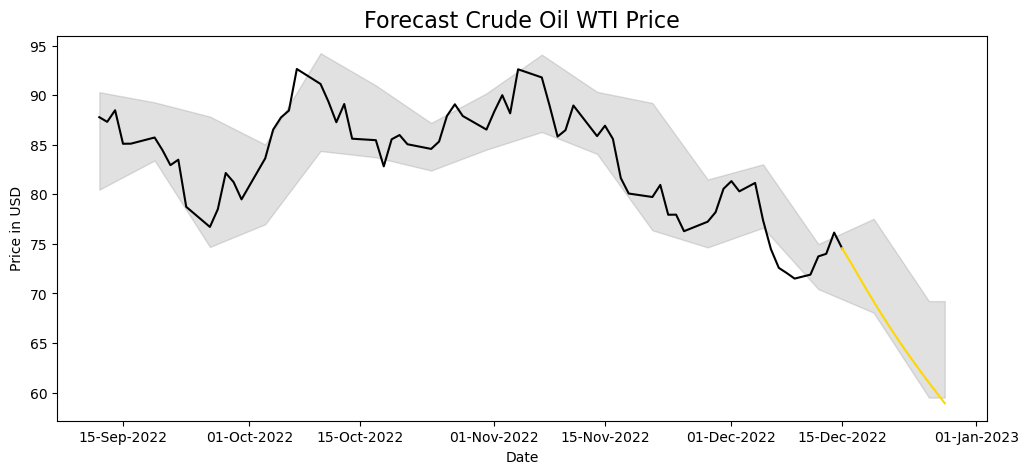

In [14]:
# green
fig, ax = plt.subplots()
plt.gcf().set_size_inches(12, 5, forward=True)
currentFig = plt.gcf()
# styling
plt.style.use('default')

# Create the line chart
plt.plot(mynewdf[-84:-13].index, mynewdf['Price'][-84:-13], color="black")
plt.plot(mynewdf[-14:].index, mynewdf['Price'][-14:], color="gold")

# Add the 95% confidence interval to the chart
plt.fill_between(mynewdf[-84:].index, mynewdf['ConfidenceLow'][-84:], mynewdf['ConfidenceHigh'][-84:], alpha=0.2, color="dimgray")


# styling
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price in USD', fontsize=10)
plt.title('Forecast Crude Oil WTI Price', fontsize=16)

# Show the chart
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b-%Y"))
# plt.grid()
# turn off the top frame
plt.frameon = False
plt.show()